**Stock Market Prediction using**<br>
Numerical and Textual Analysis
(Level - Advanced)<br>
● Objective: Create a hybrid model for stock price/performance
prediction using numerical analysis of historical stock prices, and
sentimental analysis of news headlines<br>
● Stock to analyze and predict - SENSEX (S&P BSE SENSEX)<br>
● Download historical stock prices from finance.yahoo.com<br>
● Download textual (news) data from https://bit.ly/36fFPI6<br>
● Use either R or Python, or both for separate analysis and then
combine the findings to create a hybrid model.<br>
● You are free to select a different stock to analyze and news dataset
as well while not changing the objective of the task.<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA #https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima_model.ARIMA.html
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [58]:
#Lets import other libraries for text analysis
import nltk ##https://www.nltk.org/
import re #https://docs.python.org/3/library/re.html
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer

from textblob import TextBlob #https://textblob.readthedocs.io/en/dev/
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost #https://xgboost.readthedocs.io/en/latest/
import lightgbm #https://lightgbm.readthedocs.io/en/latest/

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
#https://pypi.org/project/pmdarima/
#Pmdarima is a statistical library designed to fill the void in Python's time series analysis capabilities
!pip install pmdarima

In [5]:
#Upload CSV file using google colab
from google.colab import files
uploaded =  files.upload()

Saving BSESN.csv to BSESN.csv


In [11]:
# The dataset from yahoo finance
df_prices =  pd.read_csv('BSESN.csv')
df_prices.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-20,42263.000000,42273.871094,41503.371094,41528.910156,41528.910156,7500.0
1,2020-01-21,41487.570313,41532.589844,41294.300781,41323.808594,41323.808594,8900.0
2,2020-01-22,41467.128906,41532.289063,41059.039063,41115.378906,41115.378906,7700.0
3,2020-01-23,41191.500000,41413.960938,41098.910156,41386.398438,41386.398438,9900.0
4,2020-01-24,41377.039063,41697.031250,41275.601563,41613.191406,41613.191406,6600.0
5,2020-01-27,41510.679688,41516.269531,41122.480469,41155.121094,41155.121094,7000.0
6,2020-01-28,41299.679688,41333.250000,40869.750000,40966.859375,40966.859375,9800.0
7,2020-01-29,41131.570313,41334.859375,41108.191406,41198.660156,41198.660156,7800.0
8,2020-01-30,41380.140625,41380.140625,40829.910156,40913.820313,40913.820313,6700.0
9,2020-01-31,41146.558594,41154.488281,40671.011719,40723.488281,40723.488281,11500.0


In [13]:
df_prices.info

<bound method DataFrame.info of            Date          Open  ...     Adj Close   Volume
0    2020-01-20  42263.000000  ...  41528.910156   7500.0
1    2020-01-21  41487.570313  ...  41323.808594   8900.0
2    2020-01-22  41467.128906  ...  41115.378906   7700.0
3    2020-01-23  41191.500000  ...  41386.398438   9900.0
4    2020-01-24  41377.039063  ...  41613.191406   6600.0
..          ...           ...  ...           ...      ...
245  2021-01-12  49228.261719  ...  49517.109375  12700.0
246  2021-01-13  49763.929688  ...  49492.320313  27200.0
247  2021-01-14  49432.828125  ...  49584.160156  24500.0
248  2021-01-15  49656.710938  ...  49034.671875  14700.0
249  2021-01-18  49061.218750  ...  48564.269531      0.0

[250 rows x 7 columns]>

In [14]:
print(df_prices.size)

1750


In [15]:
#Converting Date column to datetime datatype
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       250 non-null    datetime64[ns]
 1   Open       248 non-null    float64       
 2   High       248 non-null    float64       
 3   Low        248 non-null    float64       
 4   Close      248 non-null    float64       
 5   Adj Close  248 non-null    float64       
 6   Volume     248 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 13.8 KB


In [16]:
df_prices.dropna(inplace = True)

Text(0, 0.5, 'Close')

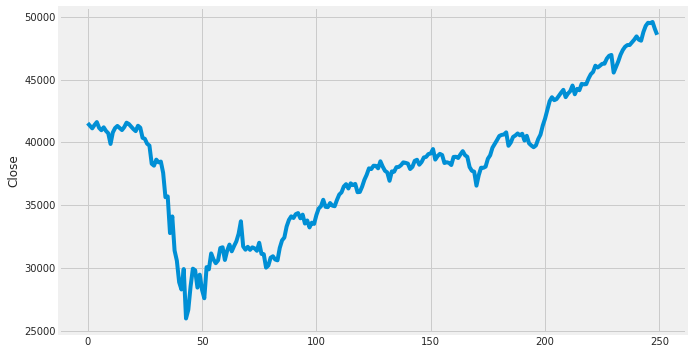

In [17]:
plt.figure(figsize=(10, 6))
df_prices['Close'].plot()
plt.ylabel('Close')

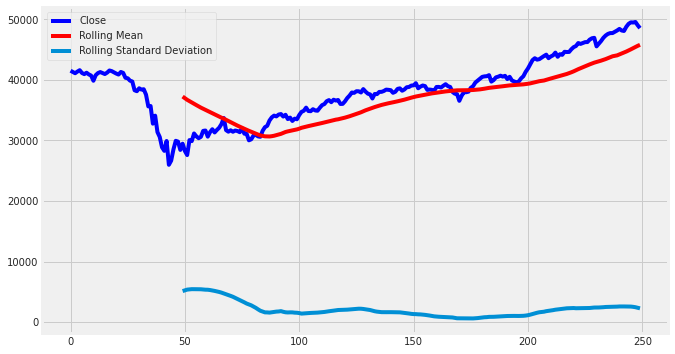

In [18]:
#Plotting moving average
close =  df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window =  50).std()

plt.figure(figsize = (10 , 6))
df_prices['Close'].plot(color = 'b' , label = 'Close')
ma.plot(color = 'r' , label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

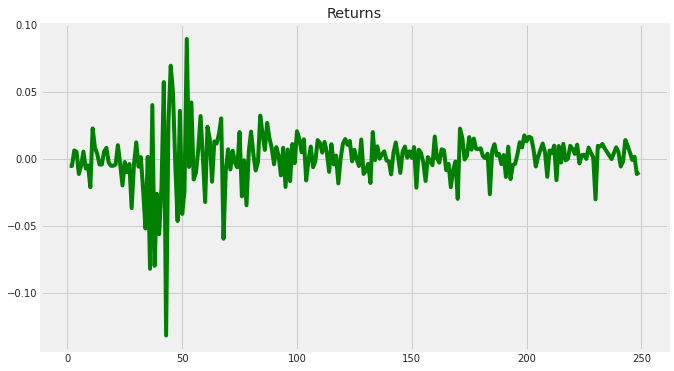

In [19]:
#Plotting Returns
returns  = close /close.shift(1)-1

plt.figure(figsize=(10 ,6))
returns.plot(label = 'Return' , color  = 'g')
plt.title("Returns")

In [33]:
#Spliting the data
train =  df_prices[:200]
test = df_prices[200:]

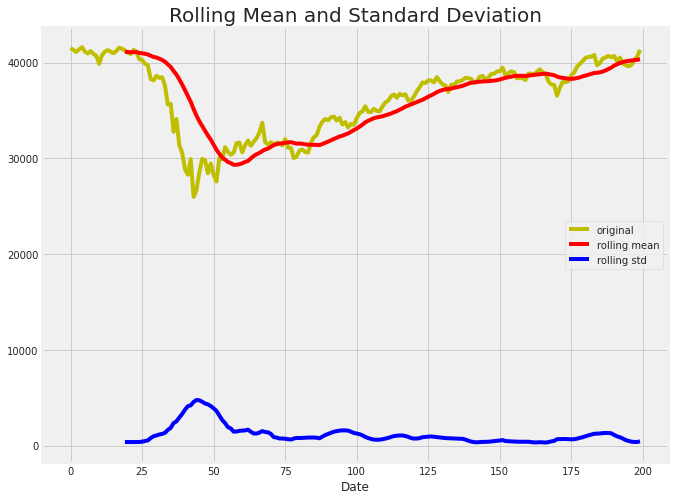

Results of dickey fuller test
ADF Test Statistic : -1.6085690991959651
p-value : 0.4792876780993105
#Lags Used : 7
Number of Observations Used : 192
Weak evidence against null hypothesis, time series is non-stationary 


In [34]:
def test_stationarity(timeseries):
 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

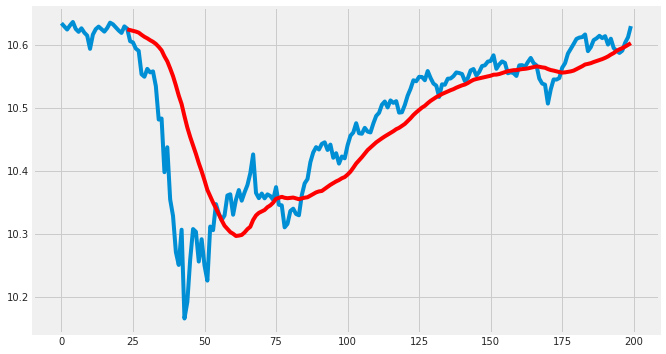

In [35]:
train_log =  np.log(train['Close'])
test_log = np.log(test['Close'])

mav =  train_log.rolling(24).mean()
plt.figure(figsize= (10 , 6))
plt.plot(train_log)
plt.plot(mav , color = 'red')

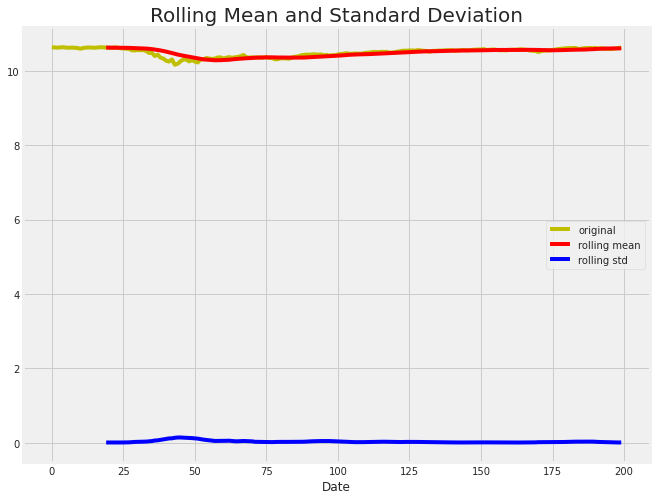

Results of dickey fuller test
ADF Test Statistic : -1.7082158129433114
p-value : 0.4268844917702149
#Lags Used : 7
Number of Observations Used : 192
Weak evidence against null hypothesis, time series is non-stationary 


In [36]:
train_log.dropna(inplace= True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

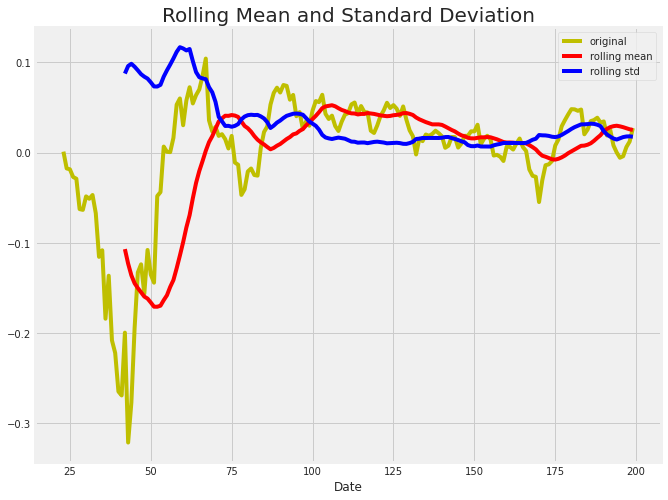

Results of dickey fuller test
ADF Test Statistic : -2.7979804302055693
p-value : 0.05856282882620621
#Lags Used : 7
Number of Observations Used : 169
Weak evidence against null hypothesis, time series is non-stationary 


In [37]:
train_log_diff = train_log -mav
train_log_diff.dropna(inplace = True)
test_stationarity(train_log_diff)

In [38]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-941.971, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-942.920, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-945.416, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-944.935, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-944.920, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-943.688, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-943.536, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-944.777, Time=0.56 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-947.415, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-945.688, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-945.535, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-946.935, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-946.777, Time=0.27 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.035 seconds


Text(0, 0.5, 'Actual Stock Price')

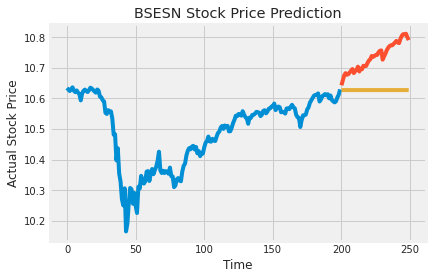

In [39]:
plt.plot(train_log , label = 'Train')
plt.plot(test_log,label = 'Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [40]:
#Calculate Error using RMS(root Mean square)
rms =  np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE: ", rms)

RMSE:  0.11713268576668327


# **TEXT DATA ANALYSIS**

In [42]:
# Uplaod the Text data set https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DPQMQH
from google.colab import files
uplaod = files.upload()

Saving india-news-headlines.csv to india-news-headlines.csv


In [52]:
cols = ['Date' , 'Category' , 'News']
df_news =  pd.read_csv('india-news-headlines.csv' , names =  cols)
df_news

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010101,sports.wwe,win over cena satisfying but defeating underta...
2,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
3,20010102,unknown,Fissures in Hurriyat over Pak visit
4,20010102,unknown,America's unwanted heading for India?
...,...,...,...
3297168,20200630,gadgets-news,why tiktok removed 1 65 crore videos in india
3297169,20200630,entertainment.hindi.bollywood,apurva asrani calls alia bhatts mother soni ra...
3297170,20200630,entertainment.hindi.bollywood,kangana ranaut gets a doll version of herself ...
3297171,20200630,entertainment.hindi.bollywood,meezaan jaffrey reminisces his childhood days ...


In [53]:
df_news.drop(0, inplace = True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3297172 entries, 1 to 3297172
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 75.5+ MB


In [54]:
#Converting data type of Date column 
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_news.head(10)

,Date,News
1,2001-01-01,win over cena satisfying but defeating underta...
2,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
3,2001-01-02,Fissures in Hurriyat over Pak visit
4,2001-01-02,America's unwanted heading for India?
5,2001-01-02,For bigwigs; it is destination Goa
6,2001-01-02,Extra buses to clear tourist traffic
7,2001-01-02,Dilute the power of transfers; says Riberio
8,2001-01-02,Focus shifts to teaching of Hindi
9,2001-01-02,IT will become compulsory in schools
10,2001-01-02,Move to stop freedom fighters' pension flayed


In [55]:
#Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2001-01-01,win over cena satisfying but defeating underta...
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-03,Powerless north India gropes in the dark Think...
3,2001-01-04,The string that pulled Stephen Hawking to Indi...
4,2001-01-05,Light combat craft takes India into club class...
...,...,...
7075,2020-06-26,Containment zone residents slam high prices ch...
7076,2020-06-27,like me i wont let you have a toxic relationsh...
7077,2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...
7078,2020-06-29,6 hot and stylish bikini looks of Katrina Kaif...


In [56]:
df_news['News']

0       win over cena satisfying but defeating underta...
1       Status quo will not be disturbed at Ayodhya; s...
2       Powerless north India gropes in the dark Think...
3       The string that pulled Stephen Hawking to Indi...
4       Light combat craft takes India into club class...
                              ...                        
7075    Containment zone residents slam high prices ch...
7076    like me i wont let you have a toxic relationsh...
7077    Atanu Ghosh plans to rewrite old scripts to ma...
7078    6 hot and stylish bikini looks of Katrina Kaif...
7079    Detective Byomkesh Bakshy! Edge of Tomorrow Fi...
Name: News, Length: 7080, dtype: object

In [67]:
#Cleaning Headlines
c = []
ps = PorterStemmer()
for i in range(0 , len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    news=' '.join(news)
    c.append(news)

In [68]:
df_news['News'] = pd.Series(c)
df_news

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,News
0,2001-01-01,win cena satisfi defeat undertak bigger roman ...
1,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...
2,2001-01-03,powerless north india grope dark think laxman ...
3,2001-01-04,string pull stephen hawk india vajpaye give bi...
4,2001-01-05,light combat craft take india club class hawk ...
...,...,...
7075,2020-06-26,contain zone resid slam high price charg veget...
7076,2020-06-27,like wont let toxic relationship food major ra...
7077,2020-06-28,atanu ghosh plan rewrit old script make relev ...
7078,2020-06-29,hot stylish bikini look katrina kaif anna eden...


In [69]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [70]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,News,Subjectivity,Polarity
0,2001-01-01,win cena satisfi defeat undertak bigger roman ...,0.450000,0.400000
1,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074
2,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000
3,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481
4,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404
...,...,...,...,...
7075,2020-06-26,contain zone resid slam high price charg veget...,0.330257,0.066958
7076,2020-06-27,like wont let toxic relationship food major ra...,0.372264,0.064784
7077,2020-06-28,atanu ghosh plan rewrit old script make relev ...,0.378165,0.054209
7078,2020-06-29,hot stylish bikini look katrina kaif anna eden...,0.373210,0.060782


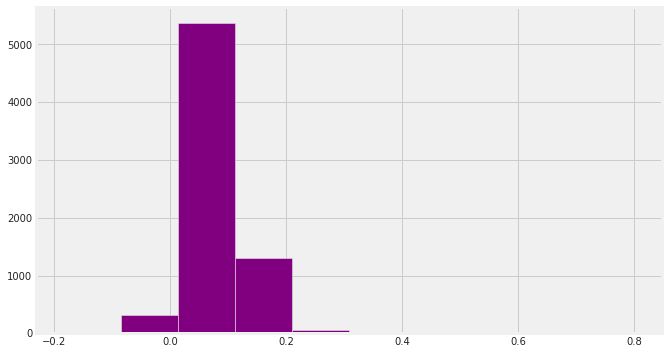

In [71]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

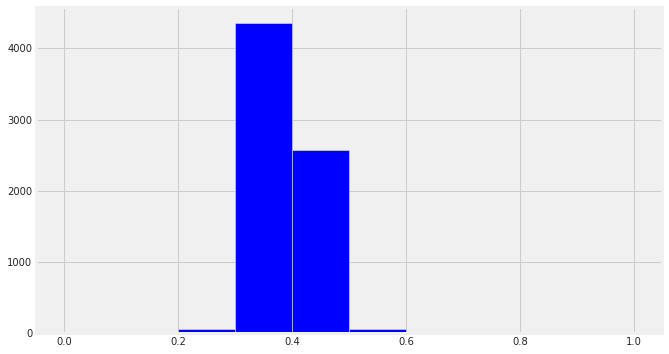

In [72]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

In [74]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-01,win cena satisfi defeat undertak bigger roman ...,0.450000,0.400000,0.2023,0.234,0.469,0.297
1,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074,-0.8555,0.125,0.773,0.102
2,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000,-0.5994,0.132,0.755,0.113
3,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481,0.9169,0.099,0.791,0.110
4,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404,-0.3612,0.171,0.659,0.170
...,...,...,...,...,...,...,...,...
7075,2020-06-26,contain zone resid slam high price charg veget...,0.330257,0.066958,-0.9998,0.142,0.789,0.069
7076,2020-06-27,like wont let toxic relationship food major ra...,0.372264,0.064784,-0.9998,0.139,0.790,0.070
7077,2020-06-28,atanu ghosh plan rewrit old script make relev ...,0.378165,0.054209,-0.9998,0.136,0.800,0.064
7078,2020-06-29,hot stylish bikini look katrina kaif anna eden...,0.373210,0.060782,-0.9998,0.130,0.800,0.070


In [78]:
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2020-01-20,42263.000000,42273.871094,41503.371094,41528.910156,41528.910156,7500.0,horoscop today januari check astrolog predict ...,0.377693,0.068002,-0.9999,0.160,0.766,0.074
1,2020-01-21,41487.570313,41532.589844,41294.300781,41323.808594,41323.808594,8900.0,wild eleph trampl man death n maha see rabi so...,0.399257,0.116144,-0.9998,0.142,0.782,0.076
2,2020-01-22,41467.128906,41532.289063,41059.039063,41115.378906,41115.378906,7700.0,man held dupe staff rs cr krrip kapur suri ble...,0.380616,0.064747,-0.9999,0.151,0.790,0.059
3,2020-01-23,41191.500000,41413.960938,41098.910156,41386.398438,41386.398438,9900.0,spurn lover attack girl kill self bangalor tim...,0.403469,0.163268,-0.9997,0.135,0.778,0.087
4,2020-01-24,41377.039063,41697.031250,41275.601563,41613.191406,41613.191406,6600.0,robber steal gold jewelleri worth rs lakh roor...,0.410347,0.102682,-0.9998,0.138,0.784,0.078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,2020-06-24,35679.738281,35706.550781,34794.929688,34868.980469,34868.980469,26600.0,never thought voic today vidya rajput never th...,0.368654,0.077799,-0.9997,0.126,0.807,0.067
105,2020-06-25,34525.390625,35081.609375,34499.781250,34842.101563,34842.101563,24600.0,truck firm look new export market sell bs rang...,0.362784,0.011935,-0.9999,0.153,0.795,0.052
106,2020-06-26,35144.781250,35254.878906,34910.339844,35171.269531,35171.269531,24800.0,contain zone resid slam high price charg veget...,0.330257,0.066958,-0.9998,0.142,0.789,0.069
107,2020-06-29,34926.949219,35032.359375,34662.058594,34961.519531,34961.519531,18300.0,hot stylish bikini look katrina kaif anna eden...,0.373210,0.060782,-0.9998,0.130,0.800,0.070


In [79]:
df = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,41528.910156,0.377693,0.068002,-0.9999,0.160,0.766,0.074
1,41323.808594,0.399257,0.116144,-0.9998,0.142,0.782,0.076
2,41115.378906,0.380616,0.064747,-0.9999,0.151,0.790,0.059
3,41386.398438,0.403469,0.163268,-0.9997,0.135,0.778,0.087
4,41613.191406,0.410347,0.102682,-0.9998,0.138,0.784,0.078
...,...,...,...,...,...,...,...
104,34868.980469,0.368654,0.077799,-0.9997,0.126,0.807,0.067
105,34842.101563,0.362784,0.011935,-0.9999,0.153,0.795,0.052
106,35171.269531,0.330257,0.066958,-0.9998,0.142,0.789,0.069
107,34961.519531,0.373210,0.060782,-0.9998,0.130,0.800,0.070


In [80]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.994608,0.598310,0.460540,0.000000,0.725490,0.213592,0.433333
1,0.981488,0.805499,0.733156,0.000728,0.549020,0.368932,0.466667
2,0.968154,0.626394,0.442111,0.000000,0.637255,0.446602,0.183333
3,0.985492,0.845959,1.000000,0.001456,0.480392,0.330097,0.650000
4,1.000000,0.912045,0.656923,0.000728,0.509804,0.388350,0.500000


In [81]:
X = new_df.drop('Close', axis=1)
y = new_df['Close']

In [82]:
X.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.598310,0.460540,0.000000,0.725490,0.213592,0.433333
1,0.805499,0.733156,0.000728,0.549020,0.368932,0.466667
2,0.626394,0.442111,0.000000,0.637255,0.446602,0.183333
3,0.845959,1.000000,0.001456,0.480392,0.330097,0.650000
4,0.912045,0.656923,0.000728,0.509804,0.388350,0.500000


In [83]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(87, 6)

In [84]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
26,0.632040,0.404647,0.000728,0.519608,0.417476,0.433333
93,0.630322,0.246447,0.001456,0.372549,0.660194,0.283333
33,0.366566,0.289611,0.000000,0.676471,0.330097,0.316667
3,0.845959,1.000000,0.001456,0.480392,0.330097,0.650000
66,0.421022,0.454838,0.014556,0.176471,0.631068,0.650000
48,0.345865,0.369178,0.010189,0.039216,1.000000,0.250000
30,0.467388,0.198766,0.000000,0.696078,0.271845,0.383333
6,0.478219,0.654097,0.000000,0.637255,0.320388,0.400000
78,0.118633,0.364662,0.000000,0.598039,0.359223,0.383333
89,0.550016,0.465716,0.000728,0.519608,0.407767,0.450000


In [85]:
rf = RandomForestRegressor()
rf.fit(x_train , y_train)
prediction = rf.predict(x_test)

In [86]:
print(prediction[:10])
print(y_test[:10])
print(mean_squared_error(prediction,y_test))

[0.33414114 0.87540535 0.34428635 0.42753479 0.85352653 0.50320593
 0.40714038 0.62519552 0.659982   0.53516264]
84     0.359775
10     0.888633
75     0.385580
2      0.968154
24     0.920038
100    0.526282
108    0.571558
7      0.973482
16     0.974600
86     0.412160
Name: Close, dtype: float64
0.052633030919200456


In [87]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)

In [ ]:
print(mean_squared_error(predictions, y_test))

In [88]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)

In [89]:
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions,y_test))

[0.         0.97069654 0.15731114 0.14758172 0.94729945 0.53667887
 0.60447921 0.30011286 0.46841749 0.79505368]
84     0.359775
10     0.888633
75     0.385580
2      0.968154
24     0.920038
100    0.526282
108    0.571558
7      0.973482
16     0.974600
86     0.412160
Name: Close, dtype: float64
0.1125799238235873


In [90]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [91]:
predictions = lgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.04104145072488143


In [92]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

[18:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [93]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions , y_test))


0.04962454986692045


# **Using LSTM Analysis on Stock Data**

In [94]:
stock1 = df_prices['Close'].copy()
stock1 = pd.DataFrame(stock1)

In [95]:
stock1

,Close
0,41528.910156
1,41323.808594
2,41115.378906
3,41386.398438
4,41613.191406
...,...
245,49517.109375
246,49492.320313
247,49584.160156
248,49034.671875


In [96]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0 , 1))
df1 = scaler.fit_transform(stock1)

In [97]:
df1.shape

(248, 1)

In [132]:
## Train test split
train_size = int(len(df1)* 0.8)
test_size =  len(df1) - train_size
initial_train_data , test_data =  df1[0:train_size, :],df1[train_size:len(df1),:1]

In [133]:
train_size , test_size 

(198, 50)

In [134]:
# Validation Data
train_data,cv_data = initial_train_data[0 : int(len(initial_train_data)*0.8)],initial_train_data[int(len(initial_train_data)*0.5):]

In [135]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [139]:
time_step = 10
Xtrain, ytrain = create_dataset(train_data, time_step)
Xtest, ytest = create_dataset(test_data, time_step)
Xcv,ycv = create_dataset(cv_data, time_step)

In [140]:
print(Xtrain.shape), print(ytrain.shape)

(147, 10)
(147,)


(None, None)

In [141]:
print(Xtest.shape), print(ytest.shape)

(39, 10)
(39,)


(None, None)

In [143]:
# reshape input to be [samples, time steps, features] which is required for LSTM
Xtrain =Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1] , 1)
Xtest = Xtest.reshape(Xtest.shape[0],Xtest.shape[1] , 1)
Xcv = Xcv.reshape(Xcv.shape[0],Xcv.shape[1] , 1)

In [145]:
### Create the Stacked LSTM model
#https://www.tensorflow.org/guide/keras/sequential_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [146]:
#Defining our metric
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [147]:
## LSTM Model Initialization
model = Sequential()
model.add(LSTM(units=128, activation='tanh', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=26), input_shape = (Xtrain.shape[1], 1), unroll = True))
model.add(Dense(1, name="output_layer"))
model.compile(optimizer = Adam(learning_rate=0.001), loss = root_mean_squared_error)

In [148]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [149]:
model.fit(Xtrain,ytrain,validation_data=(Xcv,ycv),epochs=100,batch_size=16,verbose=1)

Epoch 1/100
10/10 [==============================] - 2s 62ms/step - loss: 0.3388 - val_loss: 0.0988
Epoch 2/100
10/10 [==============================] - 0s 21ms/step - loss: 0.1195 - val_loss: 0.1276
Epoch 3/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0928 - val_loss: 0.0315
Epoch 4/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0759 - val_loss: 0.0500
Epoch 5/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0590 - val_loss: 0.0377
Epoch 6/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0592 - val_loss: 0.0347
Epoch 7/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0638 - val_loss: 0.0479
Epoch 8/100
10/10 [==============================] - 0s 18ms/step - loss: 0.0586 - val_loss: 0.0360
Epoch 9/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0584 - val_loss: 0.0481
Epoch 10/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0547 - val_loss: 0.0356

In [151]:
### Prediction and check performance metrics
train_predict=model.predict(Xtrain)
test_predict=model.predict(Xtest)

In [152]:
### Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [153]:
rescaled_ytrain = scaler.inverse_transform(ytrain.reshape(-1, 1))
rescaled_ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [157]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
math.sqrt(mean_squared_error(rescaled_ytrain,train_predict))

789.4139669835364

In [158]:
# report performance
mse = mean_squared_error(rescaled_ytest,test_predict)
print('MSE: '+str(mse))
mae = mean_absolute_error(rescaled_ytest,test_predict)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(rescaled_ytest,test_predict))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test_predict - rescaled_ytest)/np.abs(rescaled_ytest))
print('MAPE: '+str(mape))

MSE: 279884.54642158304
MAE: 409.28064905128196
RMSE: 529.0411575875577
MAPE: 0.00877392632802082


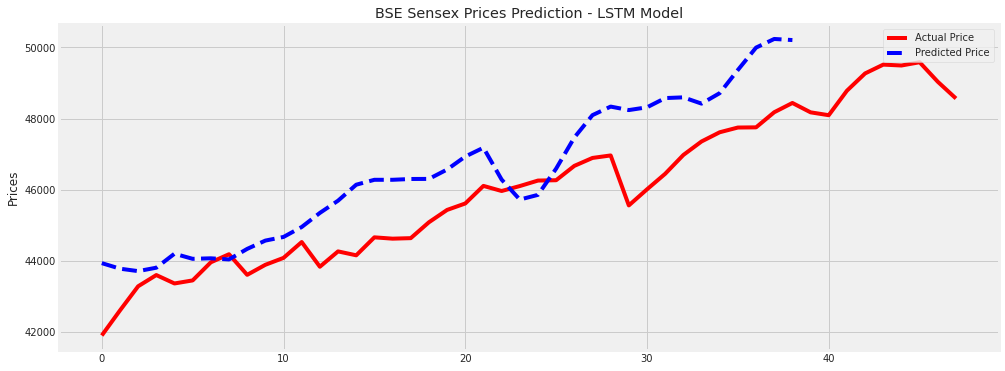

In [166]:
plt.figure(figsize=(15,6))
plt.plot(scaler.inverse_transform(df1[200:,]),color='red', label='Actual Price')
plt.plot(test_predict, color='blue', linestyle='dashed',label='Predicted Price')
plt.title('BSE Sensex Prices Prediction - LSTM Model')
plt.ylabel('Prices')
plt.legend()
plt.show()

**END**